# Build a model to recognized digits in SVHN

[notebook 1](http://localhost:8888/notebooks/Lectures/DL-Udacity/LiveCameraApp_1.ipynb)

27.08.2018

##### Read training arrays

In [1]:
SAVED_TRAIN_ARRAYS = './svhn_train_arrays.pickle'
SAVED_TRAIN_LABELS = './svhn_train_labels.pickle'

In [2]:
import pickle

In [3]:
with open(SAVED_TRAIN_ARRAYS, 'rb') as f:
    train_arrays = pickle.load(f)
    
with open(SAVED_TRAIN_LABELS, 'rb') as f:
    labels = pickle.load(f)
    
train_arrays.shape, labels.shape

((33401, 54, 54, 1), (33401, 5))

##### Split into train, validation and test 

In [4]:
import numpy as np

In [5]:
permuted = np.random.permutation(range(labels.shape[0]))

In [6]:
train_arrays = train_arrays[permuted]
labels = labels[permuted]
train_arrays.shape, labels.shape

((33401, 54, 54, 1), (33401, 5))

In [7]:
test_start = -3000
valid_start = -6000
train_dataset,train_labels = train_arrays[:valid_start], labels[:valid_start]
valid_dataset,valid_labels = train_arrays[valid_start:test_start], labels[valid_start:test_start]
test_dataset,test_labels = train_arrays[test_start:], labels[test_start:]

In [8]:
del train_arrays, labels

### Build tensorflow model

In [10]:
import tensorflow as tf
from math import ceil

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/akbars/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ceil', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
def output_size(input_size, filter_size, stride, padding):
    ''' get output size from input size '''
    if padding == 'VALID':
        return int(ceil((input_size - filter_size + 1)/stride))
    elif padding == 'SAME':
        return int(ceil(input_size / stride))
    else:
        raise Exception('Invalid padding')

In [12]:
input_channels = train_dataset.shape[3]
imgSize = train_dataset.shape[1]
numLabels = 11
maxLen = 5

batch_size = 32

In [26]:
conv_strides = [1,1,1,1,1,1]
conv_filters = [3,3,3,3,3,3]
pool_strides = [2,1,1,2,1,1]
pool_filters = [2,2,2,2,2,2]
channels = [16,64,128,128,128,128]


In [27]:
for l in range(len(channels)):
    if l == 0:
        conv_output = output_size(imgSize, conv_filters[l], conv_strides[l], 'VALID')
    else:
        conv_output = output_size(pool_output, conv_filters[l], conv_strides[l], 'VALID')
    pool_output = output_size(conv_output, pool_filters[l], pool_strides[l], 'VALID')
    print(conv_output, pool_output)
dense_units = int(pool_output * pool_output * channels[-1])
print('Dense units are', dense_units)

52 26
24 23
21 20
18 9
7 6
4 3
Dense units are 1152


In [29]:
graph = tf.Graph()

with graph.as_default():
    # define tensors for train, valid and test
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, imgSize, imgSize, input_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, maxLen))
    tf_valid_dataset = tf.constant(valid_dataset, dtype=tf.float32)
    tf_test_dataset = tf.constant(test_dataset, dtype=tf.float32)
    # initialize weights and biases for conv layers
    weights = {}
    channels_in = input_channels
    for c in range(len(channels)):
        w_name = 'weights_l' + str(c+1)
        b_name = 'biases_l' + str(c+1)
        weights[w_name] = tf.Variable(tf.truncated_normal([conv_filters[c],conv_filters[c],channels_in,channels[c]], stddev=0.1))
        weights[b_name] = tf.Variable(tf.zeros([channels[c]]))
        channels_in = channels[c]
    # weights of the fully-connected layers
    dense1_weights = tf.Variable(tf.truncated_normal([dense_units, dense_units], stddev=0.1))
    dense1_biases = tf.Variable(tf.ones([dense_units]))
    # initialize weights and biases for output layers
    o1_weights = tf.Variable(tf.truncated_normal([dense_units, numLabels], stddev=0.1))
    o1_biases = tf.Variable(tf.ones([numLabels]))
    o2_weights = tf.Variable(tf.truncated_normal([dense_units, numLabels], stddev=0.1))
    o2_biases = tf.Variable(tf.ones([numLabels]))
    o3_weights = tf.Variable(tf.truncated_normal([dense_units, numLabels], stddev=0.1))
    o3_biases = tf.Variable(tf.ones([numLabels]))
    o4_weights = tf.Variable(tf.truncated_normal([dense_units, numLabels], stddev=0.1))
    o4_biases = tf.Variable(tf.ones([numLabels]))
    o5_weights = tf.Variable(tf.truncated_normal([dense_units, numLabels], stddev=0.1))
    o5_biases = tf.Variable(tf.ones([numLabels]))
    # model
    def model(data):
        # conv layers
        for l in range(len(channels)):
            w_name = 'weights_l' + str(l + 1)
            b_name = 'biases_l' + str(l + 1)
            conv = tf.nn.conv2d(data, 
                                weights[w_name], 
                                [1,conv_strides[l],conv_strides[l],1],
                                'VALID')
            hidden = tf.nn.relu(conv) + weights[b_name]
            maxpool = tf.nn.max_pool(hidden,
                                     [1,pool_filters[l],pool_filters[l],1],
                                     [1,pool_strides[l],pool_strides[l],1],
                                     'VALID')
            data = maxpool
        # reshape matrix
        shapes = maxpool.get_shape().as_list()
        hidden = tf.reshape(maxpool, (shapes[0], shapes[1]*shapes[2]*shapes[3]))
        # fully-connected layer outputs
        logits1 = tf.matmul(hidden, o1_weights) + o1_biases
        logits2 = tf.matmul(hidden, o2_weights) + o2_biases
        logits3 = tf.matmul(hidden, o3_weights) + o3_biases
        logits4 = tf.matmul(hidden, o4_weights) + o4_biases
        logits5 = tf.matmul(hidden, o5_weights) + o5_biases
        return tf.stack([logits1, logits2, logits3, logits4, logits5], axis=0)
    
    # model output
    logits = model(tf_train_dataset)
    # define a loss function
    with tf.name_scope('loss_function') as scope:
        loss1 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,0], logits=logits[0])
        loss2 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,1], logits=logits[1])
        loss3 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,2], logits=logits[2])
        loss4 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,3], logits=logits[3])
        loss5 = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_train_labels[:,4], logits=logits[4])
        loss = tf.reduce_mean(loss1) + tf.reduce_mean(loss2) + tf.reduce_mean(loss3) + \
                    tf.reduce_mean(loss4) + tf.reduce_mean(loss5)
        tf.summary.scalar('loss_function', loss)
        
    # optimization
    optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    # Predictions for the mini training, validation, and test data.
    train_prediction = tf.transpose(tf.argmax(logits, axis = 2))
    valid_prediction =  tf.transpose(tf.argmax(model(tf_valid_dataset), axis = 2))
    test_prediction =  tf.transpose(tf.argmax(model(tf_test_dataset), axis = 2))
    # evaluate accuracies
    def eval_accuracy(predictions, labels):
        return tf.reduce_mean(tf.reduce_min(tf.to_float(tf.equal(tf.to_int32(predictions), labels)), axis = 1))
    
    train_accuracy = eval_accuracy(train_prediction, tf_train_labels)
    valid_accuracy = eval_accuracy(valid_prediction, valid_labels)
    test_accuracy = eval_accuracy(test_prediction, test_labels)
    
    # Create summaries to monitor the accuracy
    tf.summary.scalar("mini-batch_accuracy", train_accuracy)
    tf.summary.scalar("validation_accuracy", valid_accuracy)
        
    # Merge all summaries into a single operator
    merged_summary_op = tf.summary.merge_all()
    
    saver = tf.train.Saver(max_to_keep = 2)

In [37]:
nTrain = train_labels.shape[0]
num_steps = 15001 #nTrain // batch_size + 1
print_step = 100
print('Running for {} steps:\n'.format(num_steps))
# for plotting
steps = []
losses = []
tr_acc = []
val_acc = []
# for early stopping
best_val_acc = 0
streak = 0
max_streak = 450

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    summary_writer = tf.train.SummarySaverHook(save_steps=200, output_dir='.', summary_op=saver)
    
    for step in range(num_steps):
        offset = (step * batch_size) % (nTrain - batch_size)
        batch_data = train_dataset[offset:(offset+batch_size)]
        batch_labels = train_labels[offset:(offset+batch_size)]
        feed_dict = {tf_train_dataset:batch_data, tf_train_labels:batch_labels}
        
        if (step % 200 ==0):
            _, l, train_acc, summary_str = sess.run([optimizer, loss, train_accuracy,
                                                     merged_summary_op], 
                                                    feed_dict=feed_dict)
#             summary_writer.add_summary(summary_str, step)
        else:
            _, l, train_acc = sess.run([optimizer, loss, train_accuracy], feed_dict=feed_dict)
        
        if (step % print_step == 0):
            valid_acc = valid_accuracy.eval()
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % (train_acc*100))
            print('Validation accuracy: %.1f%%' % (valid_acc*100))
            print('-'*30)
            tr_acc.append(train_acc)
            val_acc.append(valid_acc)
            losses.append(l)
            steps.append(step)
        # early stopping
        if valid_acc > best_val_acc:
            best_val_acc = valid_acc
            streak = 0
        else:
            streak += 1
            if streak > max_streak:
                print('Stopping at step {} with best validation accuracy {}'.format(step, best_val_acc))
                break
            
    print('Test accuracy: %.1f%%' % (test_accuracy.eval()*100))
#     save_path = saver.save(sess, "./CNN_trained_initialModel.ckpt",global_step=step)
#     print("Model saved in file: %s" % save_path)

Running for 15001 steps:

Minibatch loss at step 0: 21.645609
Minibatch accuracy: 0.0%
Validation accuracy: 1.4%
------------------------------
Minibatch loss at step 100: 5.591238
Minibatch accuracy: 0.0%
Validation accuracy: 4.3%
------------------------------
Minibatch loss at step 200: 4.978278
Minibatch accuracy: 9.4%
Validation accuracy: 10.5%
------------------------------
Minibatch loss at step 300: 3.885663
Minibatch accuracy: 28.1%
Validation accuracy: 23.3%
------------------------------
Minibatch loss at step 400: 3.654371
Minibatch accuracy: 21.9%
Validation accuracy: 33.0%
------------------------------
Minibatch loss at step 500: 3.753618
Minibatch accuracy: 25.0%
Validation accuracy: 35.5%
------------------------------
Minibatch loss at step 600: 2.112471
Minibatch accuracy: 53.1%
Validation accuracy: 43.5%
------------------------------
Minibatch loss at step 700: 2.499352
Minibatch accuracy: 43.8%
Validation accuracy: 48.6%
------------------------------
Minibatch lo

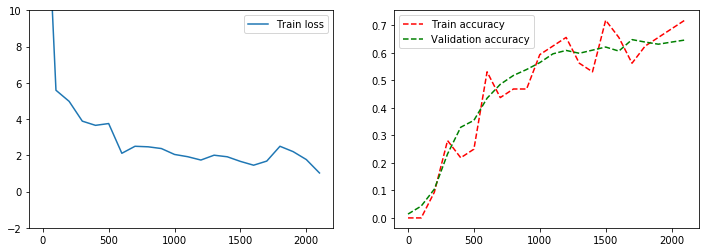

In [38]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(steps, losses, label='Train loss')
plt.axis(ymin=-2,ymax=10)
plt.legend(loc='best')
plt.subplot(122)
plt.plot(steps, tr_acc, 'r--', label='Train accuracy')
plt.plot(steps, val_acc, 'g--', label='Validation accuracy')
plt.legend(loc='best')
plt.show()

#### Ian Goodfellow paper:
- 8 conv layers + 1 locally connected layer + 2 dense layers
- 1st layer maxout activation, then relu
- conv units are [48, 64, 128, 160] then 192
- each conv layer include max pooling and subtractive normalization
- maxpool 2x2 with alternating stride 2 and 1
- all conv layers with zero padding
- sub.norm operates on 3x3 windows
- conv kernels are 5x5
- dropout at all layers but input layer